# Bernoulli-Beta Conjugate by MCMC

- We try to produce Figure 6.4 in page 135 of DBDA 2nd.
- Figure 6.4 is obtained by mathematical analysis.
- Here we produce it with MCMC. It should be almost the same. 'Almost' because of sampling approximation.

In [1]:
import numpyro 
import numpyro.distributions as dist 
from numpyro.infer import MCMC, NUTS, Predictive
import jax 
import jax.random as random 
import jax.numpy as jnp 

import matplotlib.pyplot as plt
import seaborn as sns; 
#sns.set_style("darkgrid"); 

plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
# plt.style.use("dark_background")

In [2]:
rng_key = random.PRNGKey(0)

## With Binomial Likelihood

In [3]:
def model_Binomial(a, b, N=20, z=17):
    theta = numpyro.sample('theta', dist.Beta(a, b))
    obs = numpyro.sample('obs', dist.Binomial(total_count=N, probs=theta), obs=z)

In [4]:
kernel = NUTS(model_Binomial)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=1,
            progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True)
mcmc.run(rng_key, a=100, b=100)
mcmc.print_summary(exclude_deterministic=False)

sample: 100%|██████████| 3000/3000 [00:04<00:00, 731.21it/s, 1 steps of size 1.19e+00. acc. prob=0.91]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     theta      0.53      0.03      0.53      0.48      0.59    565.43      1.00

Number of divergences: 0


In [5]:
samples = mcmc.get_samples()
samples

{'theta': DeviceArray([0.50705713, 0.50041777, 0.47321218, ..., 0.5109114 ,
              0.5106082 , 0.49346122], dtype=float32)}

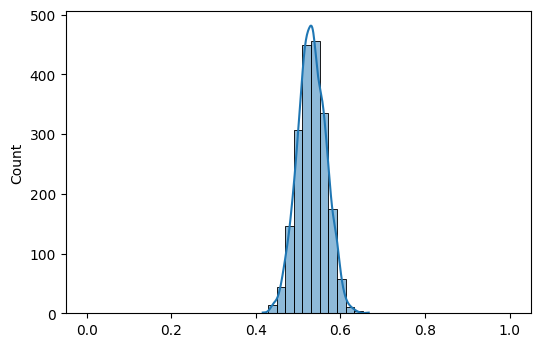

In [6]:
x = jnp.linspace(0, 1)
# plt.hist(samples['theta'], bins=x);
sns.histplot(samples['theta'], kde=True, bins=x, );

In [7]:
# HDI: High Density Interval
s = samples['theta'].sort()
hdi_prob = .94
p = (1 - hdi_prob)/2
low_index, high_index = int(s.size * p), int(s.size*(1-p))
print(f'hdi: [{s[low_index]:.3f}, {s[high_index]:.3f}]')

hdi: [0.470, 0.594]


Thee mode is at 0.531


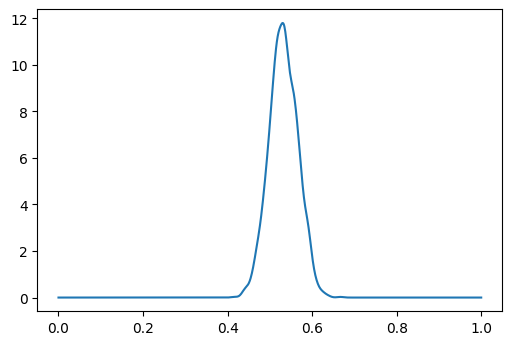

In [8]:
# Mode/Peak of the density approximation
import scipy 
kde = scipy.stats.gaussian_kde(s)  # density function approximation
x = jnp.linspace(0, 1, 1000)
probs = kde.evaluate(x) # function values at x
max_index = probs.argmax()
print(f'Thee mode is at {x[max_index]:.3f}')
plt.plot(x, probs);

In [9]:
import arviz
azdata = arviz.from_numpyro(mcmc)
azdata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

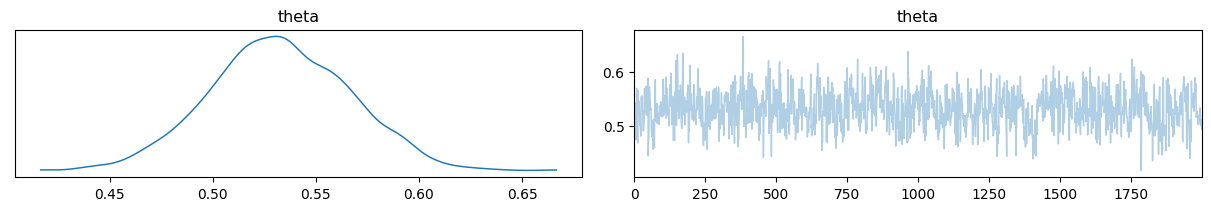

In [10]:
arviz.plot_trace(azdata);

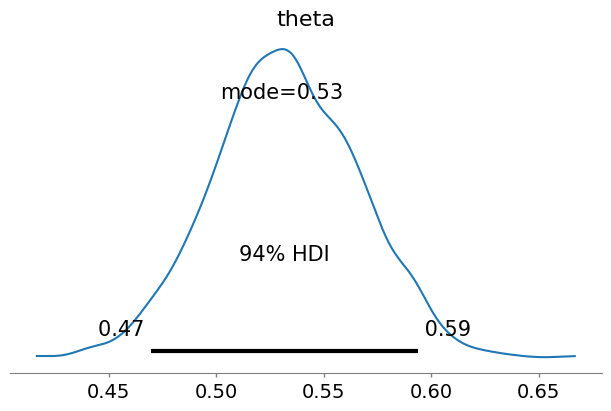

In [11]:
arviz.plot_posterior(azdata, point_estimate='mode', bins=x);

## With Bernoulli Likelihood

In [12]:
def model_Bernoulli(a, b, y=None):
    theta = numpyro.sample('theta', dist.Beta(a, b))
    with numpyro.plate('plate', size=len(y) if y is not None else 1):
        obs = numpyro.sample('obs', dist.Bernoulli(probs=theta), obs=y)
#

In [13]:
# generate an observation (z=17, N=20)
y = jnp.array([1.]*17 + [0.]*3)
print('y:', y)

y: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]


In [14]:
kernel = NUTS(model_Bernoulli)
mcmc = MCMC(kernel, num_warmup=3000, num_samples=8000, num_chains=1,
            progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True)
mcmc.run(rng_key, a=100, b=100, y=y)
mcmc.print_summary(exclude_deterministic=False)

sample: 100%|██████████| 11000/11000 [00:10<00:00, 1051.34it/s, 3 steps of size 1.11e+00. acc. prob=0.91]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     theta      0.53      0.03      0.53      0.48      0.58   3009.54      1.00

Number of divergences: 0


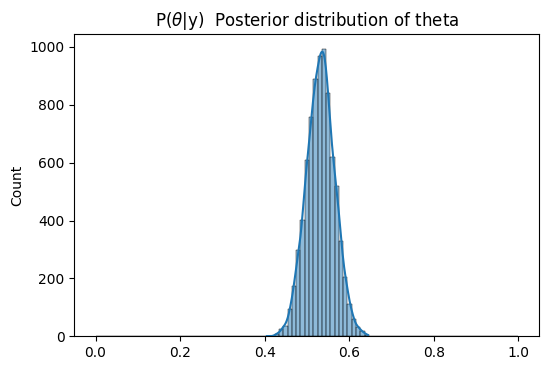

In [15]:
samples = mcmc.get_samples()
x = jnp.linspace(0, 1, 100)
ax = sns.histplot(samples['theta'], kde=True, bins=x);
ax.set(title='P($\\theta$|y)  Posterior distribution of theta');

In [16]:
# HDI: High Density Interval
s = samples['theta'].sort()
hdi_prob = .94
p = (1 - hdi_prob)/2
low_index, high_index = int(s.size * p), int(s.size*(1-p))
print(f'hdi: [{s[low_index]:.3f}, {s[high_index]:.3f}]')

hdi: [0.470, 0.596]


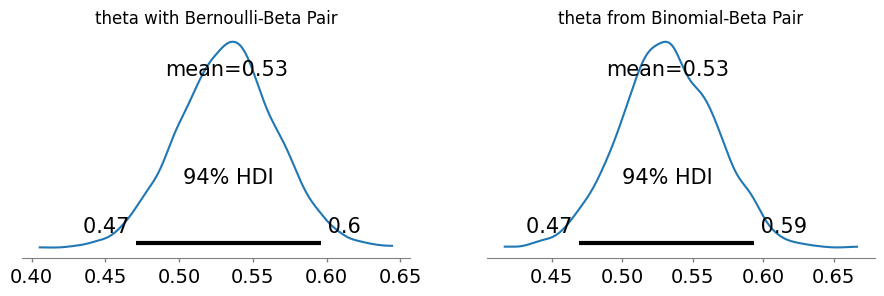

In [17]:
azdata_bernoulli = arviz.from_numpyro(mcmc)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11, 3))
arviz.plot_posterior(azdata_bernoulli, ax=ax1);
ax1.set(title='theta with Bernoulli-Beta Pair')
arviz.plot_posterior(azdata, ax=ax2); ax2.set(title='theta from Binomial-Beta Pair');

## Compare MCMC with the theoretical posterior

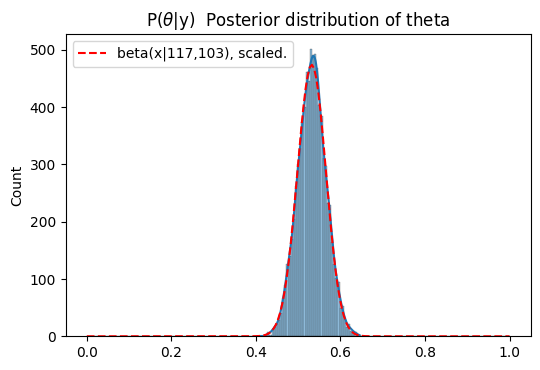

In [18]:
aa = 100 + 17
bb = 100 + 3
x = jnp.linspace(0,1,200)
pdf = jax.scipy.stats.beta.pdf(x, aa, bb)  # https://jax.readthedocs.io/en/latest/_autosummary/jax.scipy.stats.beta.pdf.html

# plot pdf, overlayed on the sample histogram chart.
samples = mcmc.get_samples()
ax = sns.histplot(samples['theta'], kde=True, bins=x);
ax.set(title='P($\\theta$|y)  Posterior distribution of theta');
ax.plot(x, pdf*40, 'r--', label=f'beta(x|{aa},{bb}), scaled.');
ax.legend();

End.